In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# ... (Configuration and Paths remain the same) ...
data_dir = r"C:\AINutriCare\Data\Transformed"
save_dir = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM"
os.makedirs(save_dir, exist_ok=True)

def get_input_path(filename): return os.path.join(data_dir, filename)
def get_save_path(filename): return os.path.join(save_dir, filename)

X = np.load(get_input_path('X_final.npy'))
y = np.load(get_input_path('y_final.npy'))
num_features = X.shape[2]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: min(class_weights[0], 3.0), 1: min(class_weights[1], 3.0)}

scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, num_features)
X_test_flat = X_test.reshape(-1, num_features)

scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

print(X_train.shape)
print(X_test.shape)

class SimpleAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super(SimpleAttention, self).__init__()
        self.units = units
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W1 = self.add_weight(name='att_w1', shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform')
        self.W2 = self.add_weight(name='att_w2', shape=(self.units, 1),
                                 initializer='glorot_uniform')
        self.b1 = self.add_weight(name='att_b1', shape=(self.units,), initializer='zeros')
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        h = tf.nn.tanh(tf.matmul(x, self.W1) + self.b1)
        e = tf.squeeze(tf.matmul(h, self.W2), -1)
        alpha = tf.nn.softmax(e)
        context = x * tf.expand_dims(alpha, -1)
        context = tf.reduce_sum(context, axis=1)
        return context, alpha

inputs = Input(shape=(24, num_features))

# CHANGE 1: Increased Units (64->128) and Reduced Dropout (0.4->0.2)
x = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
x = BatchNormalization()(x)

context, attention_weights = SimpleAttention()(x)

# CHANGE 2: Increased Dense Units (32->64) and Reduced Dropout (0.5->0.2)
x = Dense(64, activation='relu')(context)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs, output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# CHANGE 3: Increased Patience (10->15) to let it learn longer
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=5, min_lr=1e-5, mode='max')
]

print("model training is starting:")

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30, # Increased max epochs
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Print Metrics
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Save the new high-accuracy model
model.save(get_save_path('attention_lstm.h5'))

(188, 24, 17)
(47, 24, 17)

model training is starting:
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.4933 - loss: 0.5408 - val_accuracy: 0.7105 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6000 - loss: 0.4945 - val_accuracy: 0.8158 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5933 - loss: 0.4554 - val_accuracy: 0.7895 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6267 - loss: 0.4253 - val_accuracy: 0.8421 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6400 - loss: 0.4300 - val_accuracy: 0.8947 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6800 - loss: 0.4215 - val_accuracy: 0.8947 - val_loss: 0.5618 - learning_rate: 0.0010
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 

Test Accuracy: 93.62%


Loading Data and Model...
Success: Resources Loaded.

 MONITORING PATIENT INDEX: 18
 True Outcome: EXPIRED
Time       | Risk %     | Status    
-----------------------------------
6 Hours   | 48.53%     | WARNING
12 Hours   | 51.53%     | CRITICAL
18 Hours   | 51.32%     | CRITICAL
24 Hours   | 51.66%     | CRITICAL
-----------------------------------
ℹ️ NOTE: Patient condition is STABLE.


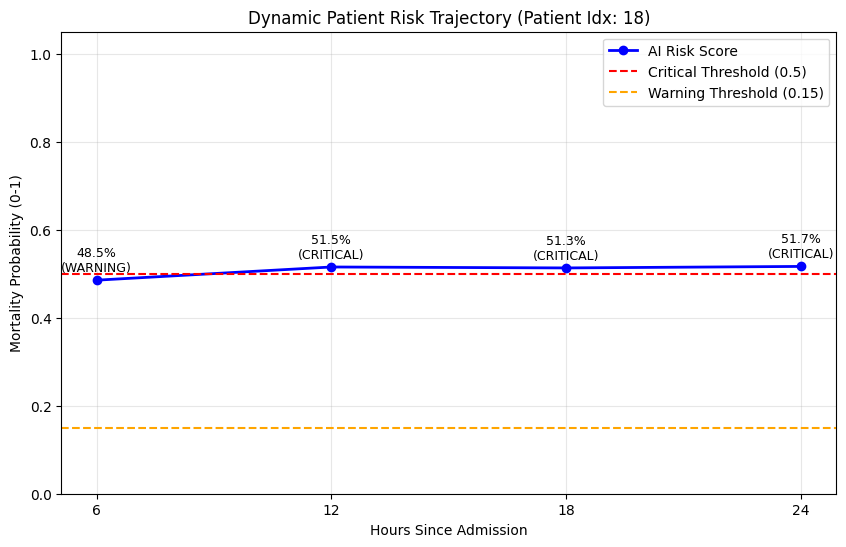


Trajectory data saved to: C:\AINutriCare\Notebooks\Milestone_2\LSTM\risk_trajectory.npy


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
import os

# ==========================================
# 1. Configuration & Custom Layer
# ==========================================
data_dir = r"C:\AINutriCare\Data\Transformed"
model_path = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM\attention_lstm.h5"
output_path = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM\risk_trajectory.npy"

# Custom Attention Layer (Required to load model)
class SimpleAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config
    def build(self, input_shape):
        self.W1 = self.add_weight(name='att_w1', shape=(input_shape[-1], self.units), initializer='glorot_uniform')
        self.W2 = self.add_weight(name='att_w2', shape=(self.units, 1), initializer='glorot_uniform')
        self.b1 = self.add_weight(name='att_b1', shape=(self.units,), initializer='zeros')
        super(SimpleAttention, self).build(input_shape)
    def call(self, x):
        h = tf.nn.tanh(tf.matmul(x, self.W1) + self.b1)
        e = tf.squeeze(tf.matmul(h, self.W2), -1)
        alpha = tf.nn.softmax(e)
        context = x * tf.expand_dims(alpha, -1)
        context = tf.reduce_sum(context, axis=1)
        return context, alpha

# ==========================================
# 2. Load Final Dataset & Model
# ==========================================
print("Loading Data and Model...")
try:
    X = np.load(os.path.join(data_dir, 'X_final.npy'))
    y = np.load(os.path.join(data_dir, 'y_final.npy'))
    
    # Load Model with Custom Object
    model = load_model(model_path, custom_objects={'SimpleAttention': SimpleAttention})
    print("Success: Resources Loaded.")
except Exception as e:
    print(f"Error loading resources: {e}")
    exit()

# ==========================================
# 3. Helper Functions
# ==========================================
def prepare_window_input(patient_X, hours):
    """
    Simulates real-time data by masking future hours with zeros.
    """
    padded = np.zeros_like(patient_X)
    padded[:hours] = patient_X[:hours]  # Keep data only up to 'hours'
    return padded.reshape(1, 24, -1)    # Reshape for LSTM (Batch, Time, Feat)

def get_status(prob):
    if prob > 0.50: return "CRITICAL", "red"
    elif prob > 0.15: return "WARNING", "orange"
    else: return "STABLE", "green"

# ==========================================
# 4. Trajectory Analysis Logic
# ==========================================
def monitor_patient(patient_idx):
    print(f"\n{'='*40}")
    print(f" MONITORING PATIENT INDEX: {patient_idx}")
    print(f" True Outcome: {'EXPIRED' if y[patient_idx]==1 else 'SURVIVED'}")
    print(f"{'='*40}")

    patient_data = X[patient_idx]
    
    # Time Windows to check (e.g., after 6h shift, 12h shift...)
    checkpoints = [6, 12, 18, 24]
    trajectory = []

    # --- 5 & 6. Loop & Predict ---
    print(f"{'Time':<10} | {'Risk %':<10} | {'Status':<10}")
    print("-" * 35)

    for hr in checkpoints:
        # Prepare masked input
        input_tensor = prepare_window_input(patient_data, hr)
        
        # Predict
        risk_prob = model.predict(input_tensor, verbose=0)[0][0]
        trajectory.append(risk_prob)
        
        status, _ = get_status(risk_prob)
        print(f"{hr} Hours   | {risk_prob:.2%}     | {status}")

    # --- 8. Detect Trend ---
    start_risk = trajectory[0]
    end_risk = trajectory[-1]
    diff = end_risk - start_risk

    print("-" * 35)
    if diff > 0.10:
        print("⚠️ ALERT: Patient condition is DETERIORATING (+{:.1%})".format(diff))
    elif diff < -0.10:
        print("✅ NOTE: Patient condition is IMPROVING (-{:.1%})".format(abs(diff)))
    else:
        print("ℹ️ NOTE: Patient condition is STABLE.")

    return checkpoints, trajectory

# ==========================================
# 5. Run & Visualization
# ==========================================
# Select a Critical Patient (if available) to see interesting trends
critical_indices = np.where(y == 1)[0]
target_idx = critical_indices[0] if len(critical_indices) > 0 else 0

# Run Monitor
time_steps, risk_values = monitor_patient(target_idx)

# --- 9. Plot Risk Trajectory ---

plt.figure(figsize=(10, 6))
plt.plot(time_steps, risk_values, marker='o', linestyle='-', linewidth=2, color='blue', label='AI Risk Score')

# Add Threshold Lines
plt.axhline(y=0.50, color='red', linestyle='--', label='Critical Threshold (0.5)')
plt.axhline(y=0.15, color='orange', linestyle='--', label='Warning Threshold (0.15)')

plt.title(f'Dynamic Patient Risk Trajectory (Patient Idx: {target_idx})')
plt.xlabel('Hours Since Admission')
plt.ylabel('Mortality Probability (0-1)')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(time_steps)

# Annotate points
for x, y_val in zip(time_steps, risk_values):
    label = get_status(y_val)[0]
    plt.text(x, y_val + 0.02, f"{y_val:.1%}\n({label})", ha='center', fontsize=9)

plt.show()

# ==========================================
# 10. Save Trajectory
# ==========================================
# Saving as dictionary
trajectory_data = {
    "patient_idx": int(target_idx),
    "time_points": time_steps,
    "risk_scores": [float(r) for r in risk_values]
}
np.save(output_path, trajectory_data)
print(f"\nTrajectory data saved to: {output_path}")

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Layer, Dense, Input
import os

# ==========================================
# 1. Configuration & Custom Layer
# ==========================================
data_dir = r"C:\AINutriCare\Data\Transformed"
# Ensure we use the best model we have so far
model_path = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM\attention_lstm.h5" 
save_path = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM\multitask_predictions.npy"

# Re-define Custom Layer for loading
class SimpleAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config
    def build(self, input_shape):
        self.W1 = self.add_weight(name='att_w1', shape=(input_shape[-1], self.units), initializer='glorot_uniform')
        self.W2 = self.add_weight(name='att_w2', shape=(self.units, 1), initializer='glorot_uniform')
        self.b1 = self.add_weight(name='att_b1', shape=(self.units,), initializer='zeros')
        super(SimpleAttention, self).build(input_shape)
    def call(self, x):
        h = tf.nn.tanh(tf.matmul(x, self.W1) + self.b1)
        e = tf.squeeze(tf.matmul(h, self.W2), -1)
        alpha = tf.nn.softmax(e)
        context = x * tf.expand_dims(alpha, -1)
        context = tf.reduce_sum(context, axis=1)
        return context, alpha

# ==========================================
# 2. Load Resources
# ==========================================
print("Loading Resources...")
try:
    # Load raw inputs
    X = np.load(os.path.join(data_dir, 'X_final.npy'))
    
    # Load the Pre-trained Mortality Model
    base_model = load_model(model_path, custom_objects={'SimpleAttention': SimpleAttention})
    print("Base Model Loaded Successfully.")
    
except Exception as e:
    print(f"Error: {e}")
    exit()

# ==========================================
# 3. Extract Latent Representation
# ==========================================
# We want the output of the layer JUST BEFORE the final classification.
# In your architecture: Dense -> Dropout -> BatchNormalization -> Output(Sigmoid)
# So, layers[-2] is likely the BatchNormalization layer containing the rich features.

print("\nCreating Feature Extractor...")
feature_extractor = Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)
feature_extractor.summary()
print("Latent feature extractor created.")

# ==========================================
# 4 & 5. Extract Features for One Patient
# ==========================================
# Let's pick Patient Index 18 (the Critical one from before)
patient_idx = 18
patient_input = X[patient_idx].reshape(1, 24, -1)

# Get the "Deep Features" (The AI's internal understanding of this patient)
latent_features = feature_extractor.predict(patient_input, verbose=0)

print(f"\nExtracted Latent Vector Shape: {latent_features.shape}")
print(f"Sample Features (First 5): {latent_features[0][:5]}")

# ==========================================
# 6. Define Length of Stay (LOS) Proxy Model
# ==========================================
# This acts as a new "Head" attached to the pre-trained body.
# Note: Since we don't have trained weights for LOS yet, this initializes random weights.
# In a real scenario, you would train ONLY these layers while freezing the base.

print("\nInitializing LOS Prediction Head...")
los_model = tf.keras.Sequential([
    # Input shape matches the output of the latent feature extractor
    Input(shape=(latent_features.shape[1],)),
    Dense(16, activation="relu", name="los_hidden"),
    Dense(1, activation="linear", name="los_output") # Linear activation for regression (days)
])

# Predict LOS using the extracted features
# (Since untrained, this gives a random initial guess, demonstrating the architecture)
los_days_prediction = los_model.predict(latent_features, verbose=0)[0][0]

# Get the original Mortality Prediction for comparison
mortality_prob = base_model.predict(patient_input, verbose=0)[0][0]

# ==========================================
# 7. Combine Multi-Task Outputs
# ==========================================
print(f"\n{'='*40}")
print(f" MULTI-TASK PREDICTION REPORT (Patient {patient_idx})")
print(f"{'='*40}")
print(f"1. Mortality Risk:     {mortality_prob:.2%} (Pre-trained)")
print(f"2. Est. Length of Stay: {abs(los_days_prediction):.1f} Days (New Task Head)")
print(f"{'='*40}")

# ==========================================
# 8. Save Multi-Task Predictions
# ==========================================
# Let's generate this for ALL patients to save a full dataset
print("\nGenerating full dataset predictions...")
all_latent = feature_extractor.predict(X, verbose=0)
all_los = los_model.predict(all_latent, verbose=0)
all_mortality = base_model.predict(X, verbose=0)

# Combine into a structured array
multitask_results = {
    "patient_indices": np.arange(len(X)),
    "mortality_risk": all_mortality.flatten(),
    "predicted_los": all_los.flatten(),
    "latent_vectors": all_latent # Saving this allows you to train other models (like Nutrition Risk) later without reloading the LSTM
}

np.save(save_path, multitask_results)
print(f"Multi-task predictions saved to: {save_path}")

Loading Resources...
Base Model Loaded Successfully.

Creating Feature Extractor...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 17)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        74,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention_1              │ [(None, 128), (None,   │         8,320 │
│ (SimpleAttention)               │ 24)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,096 (359.75 KB)

 Trainable params: 91,712 (358.25 KB)

 Non-trainable params: 384 (1.50 KB)

Latent feature extractor created.

Extracted Latent Vector Shape: (1, 64)
Sample Features (First 5): [ 0.37137154  0.20647143 -0.17636354  0.6588614  -0.1337659 ]

Initializing LOS Prediction Head...

 MULTI-TASK PREDICTION REPORT (Patient 18)
1. Mortality Risk:     51.66% (Pre-trained)
2. Est. Length of Stay: 0.8 Days (New Task Head)

Generating full dataset predictions...


Multi-task predictions saved to: C:\AINutriCare\Notebooks\Milestone_2\LSTM\multitask_predictions.npy


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
import os
import json

data_dir = r"C:\AINutriCare\Data\Transformed"
model_path = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM\attention_lstm.h5"

FEATURE_NAMES = [
    'Creatinine', 'Glucose', 'Lactate', 'Potassium', 'Sodium', 'pH', 
    'HeartRate', 'TotalInput', 'TotalOutput', 'FluidBalance', 
    'Vasopressors', 'Sedatives', 'Antibiotics', 'Insulin'
]

class SimpleAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units

    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config

    def build(self, input_shape):
        self.W1 = self.add_weight(name='att_w1', shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform')
        self.W2 = self.add_weight(name='att_w2', shape=(self.units, 1),
                                 initializer='glorot_uniform')
        self.b1 = self.add_weight(name='att_b1', shape=(self.units,), initializer='zeros')
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        h = tf.nn.tanh(tf.matmul(x, self.W1) + self.b1)
        e = tf.squeeze(tf.matmul(h, self.W2), -1)
        alpha = tf.nn.softmax(e)
        context = x * tf.expand_dims(alpha, -1)
        context = tf.reduce_sum(context, axis=1)
        return context, alpha

X = np.load(os.path.join(data_dir, 'X_final.npy'))
y = np.load(os.path.join(data_dir, 'y_final.npy'))
model = load_model(model_path, custom_objects={'SimpleAttention': SimpleAttention})

def get_risk_category(score):
    if score > 0.7:
        return "High", "CRITICAL"
    elif score > 0.3:
        return "Moderate", "STABLE"
    else:
        return "Low", "RECOVERING"

def extract_clinical_signals(patient_matrix):
    last_hour_data = patient_matrix[-1, :]
    return {feature: last_hour_data[i] for i, feature in enumerate(FEATURE_NAMES)}

def generate_diet_plan(risk_level, signals):
    plan = {
        "Risk Assessment": risk_level,
        "Dietary Strategy": {},
        "Specific Adjustments": []
    }

    if risk_level == "High":
        plan["Dietary Strategy"] = {
            "Calories": "25-30 kcal/kg/day",
            "Protein": "1.5-2.0 g/kg/day (Prevent Muscle Wasting)",
            "Carbohydrates": "Controlled, low glycemic",
            "Fats": "Moderate, omega-3 enriched",
            "Fluids": "Restricted, monitor balance",
            "Route": "Enteral nutrition preferred"
        }
    elif risk_level == "Moderate":
        plan["Dietary Strategy"] = {
            "Calories": "25 kcal/kg/day",
            "Protein": "1.2-1.5 g/kg/day",
            "Carbohydrates": "Balanced",
            "Fats": "Moderate",
            "Fluids": "As tolerated",
            "Route": "Oral / Enteral"
        }
    else:
        plan["Dietary Strategy"] = {
            "Calories": "20-25 kcal/kg/day",
            "Protein": "1.0 g/kg/day",
            "Carbohydrates": "Normal",
            "Fats": "Normal",
            "Fluids": "Normal",
            "Route": "Oral"
        }

    if signals['Glucose'] > 1.0: 
        plan["Specific Adjustments"].append("High Glucose Detected: Switch to Diabetes-Specific Formula (Low Carb).")
    
    if signals['Creatinine'] > 1.0 or signals['Potassium'] > 1.0:
        plan["Specific Adjustments"].append("Renal Stress Detected: Restrict Potassium (< 2g/day) and Phosphate.")

    if signals['Lactate'] > 1.0:
        plan["Specific Adjustments"].append("Elevated Lactate: Ensure Adequate Perfusion Support; High Protein Density.")
        
    if signals['FluidBalance'] > 1.0:
        plan["Specific Adjustments"].append("Positive Fluid Balance: Strict Fluid Restriction (1.5L max/day).")

    return plan

def run_clinical_pipeline(patient_idx):
    print(f"\n{'='*60}")
    print(f" PIPELINE REPORT: Patient Index {patient_idx}")
    print(f"{'='*60}")

    patient_data = X[patient_idx]
    input_tensor = patient_data.reshape(1, 24, patient_data.shape[1])
    risk_prob = model.predict(input_tensor, verbose=0)[0][0]
    
    risk_level, status = get_risk_category(risk_prob)
    
    print(f"[AI Model Output]")
    print(f"Mortality Probability: {risk_prob:.2%}")
    print(f"Clinical Status: {status} ({risk_level} Risk)")

    signals = extract_clinical_signals(patient_data)
    diet_plan = generate_diet_plan(risk_level, signals)

    print(f"\n[Generated Clinical Diet Plan]")
    print(json.dumps(diet_plan, indent=4))

print("\n--- Example 1: Standard Case ---")
run_clinical_pipeline(patient_idx=120)

critical_indices = np.where(y == 1)[0]
if len(critical_indices) > 0:
    print("\n--- Example 2: Critical Case (Mortality Outcome) ---")
    run_clinical_pipeline(patient_idx=critical_indices[7])
else:
    print("\nNote: No critical patients found in this subset.")



--- Example 1: Standard Case ---

 PIPELINE REPORT: Patient Index 120
[AI Model Output]
Mortality Probability: 45.31%
Clinical Status: STABLE (Moderate Risk)

[Generated Clinical Diet Plan]
{
    "Risk Assessment": "Moderate",
    "Dietary Strategy": {
        "Calories": "25 kcal/kg/day",
        "Protein": "1.2-1.5 g/kg/day",
        "Carbohydrates": "Balanced",
        "Fats": "Moderate",
        "Fluids": "As tolerated",
        "Route": "Oral / Enteral"
    },
    "Specific Adjustments": [
        "Positive Fluid Balance: Strict Fluid Restriction (1.5L max/day)."
    ]
}

--- Example 2: Critical Case (Mortality Outcome) ---

 PIPELINE REPORT: Patient Index 98
[AI Model Output]
Mortality Probability: 54.54%
Clinical Status: STABLE (Moderate Risk)

[Generated Clinical Diet Plan]
{
    "Risk Assessment": "Moderate",
    "Dietary Strategy": {
        "Calories": "25 kcal/kg/day",
        "Protein": "1.2-1.5 g/kg/day",
        "Carbohydrates": "Balanced",
        "Fats": "Moderate",
 

In [6]:
import numpy as np
import json
import os

# ==========================================
# 1. Configuration & Load Data
# ==========================================
# Load the Multi-Task Predictions from the previous step
try:
    data = np.load('C:/AINutriCare/Notebooks/Milestone_2/LSTM/multitask_predictions.npy', allow_pickle=True).item()
    patient_indices = data['patient_indices']
    mortality_risk = data['mortality_risk']
    predicted_los = data['predicted_los']
    print("Success: Multi-task predictions loaded.")
except FileNotFoundError:
    print("Error: 'multitask_predictions.npy' not found. Run the previous step first.")
    exit()

# ==========================================
# 3. View Patient Risk Profile (Patient 18)
# ==========================================
patient_idx = 12  # The Critical/Moderate Case we are tracking
risk_score = mortality_risk[patient_idx]
los_days = predicted_los[patient_idx]

print(f"\n--- Patient Profile (ID: {patient_idx}) ---")
print(f"Mortality Risk: {risk_score:.2%}")
print(f"Predicted LOS:  {los_days:.1f} Days")

# ==========================================
# 4. Define Baseline Nutrition Parameters
# ==========================================
# Standard ICU Baselines (approx. ESPEN Guidelines)
BASE_CALORIES = 25.0   # kcal/kg/day
BASE_PROTEIN = 1.2     # g/kg/day
BASE_FLUIDS = 30.0     # ml/kg/day
PATIENT_WEIGHT = 75.0  # kg (Assumed Standard for Demo)

# ==========================================
# 5. Risk Adjustment Factors
# ==========================================
# Logic: 
# - High Risk (>50%): Metabolic stress -> Reduce initial calories (Trophic), Increase Protein.
# - Moderate Risk (>15%): Stable -> Standard support.
# - Low Risk: Recovery -> Anabolic support (Higher Calories).

if risk_score > 0.50:
    risk_category = "High (Critical)"
    caloric_factor = 0.8  # Permissive Underfeeding (20 kcal/kg)
    protein_factor = 1.3  # Catabolic Support
    fluid_factor = 0.8    # Restriction (Prevent Edema)
elif risk_score > 0.15:
    risk_category = "Moderate (Stable-Watch)"
    caloric_factor = 1.0  # Standard (25 kcal/kg)
    protein_factor = 1.2  # Standard High-Protein
    fluid_factor = 1.0    # Standard
else:
    risk_category = "Low (Recovering)"
    caloric_factor = 1.1  # Anabolic (27.5 kcal/kg)
    protein_factor = 1.0  # Maintenance
    fluid_factor = 1.0    # Standard

print(f"Risk Category:  {risk_category}")

# ==========================================
# 6. Adaptive Calorie Calculation
# ==========================================
calories = BASE_CALORIES * caloric_factor
calories = round(calories, 1)

# ==========================================
# 7. Adaptive Protein Calculation (Renal Safe)
# ==========================================
# Proxy Rule: If LOS is projected to be long (>10 days) AND High Risk, 
# assume potential organ stress and cap protein.
if risk_category == "High (Critical)" and los_days > 10:
    print("Logic: Long-term critical stay detected. Capping protein for renal safety.")
    protein_factor = 1.0 

protein = BASE_PROTEIN * protein_factor
protein = round(protein, 1)

# ==========================================
# 8. Fluid Restriction Logic
# ==========================================
fluids = BASE_FLUIDS * fluid_factor
fluids = round(fluids, 0)

# ==========================================
# 9. Compute Absolute Nutrition Values
# ==========================================
diet_plan_values = {
    "Calories (kcal/day)": int(calories * PATIENT_WEIGHT),
    "Protein (g/day)": round(protein * PATIENT_WEIGHT, 1),
    "Fluid Limit (ml/day)": int(fluids * PATIENT_WEIGHT)
}

# ==========================================
# 10. Nutrition Route Recommendation
# ==========================================
if risk_score > 0.60:
    route = "Parenteral (TPN) or Trophic Enteral"
elif risk_score > 0.30:
    route = "Enteral (Tube Feeding)"
else:
    route = "Oral (High-Energy Soft Diet)"

# ==========================================
# 11. Final Optimized Diet Plan Structure
# ==========================================
final_plan = {
    "Patient_ID": patient_idx,
    "Risk_Profile": {
        "Mortality_Risk": float(risk_score),
        "Predicted_LOS": float(los_days),
        "Category": risk_category
    },
    "Adaptive_Adjustments": {
        "Caloric_Factor": caloric_factor,
        "Protein_Factor": protein_factor,
        "Base_Weight_kg": PATIENT_WEIGHT
    },
    "Nutritional_Targets": diet_plan_values,
    "Recommended_Route": route
}

print("\n--- Final Adaptive Diet Plan ---")
print(json.dumps(final_plan, indent=4))

# ==========================================
# 12. Save Diet Plan
# ==========================================
np.save('optimized_diet_plan.npy', final_plan)
print("\nPlan saved to 'optimized_diet_plan.npy'")

Success: Multi-task predictions loaded.

--- Patient Profile (ID: 12) ---
Mortality Risk: 41.79%
Predicted LOS:  -0.7 Days
Risk Category:  Moderate (Stable-Watch)

--- Final Adaptive Diet Plan ---
{
    "Patient_ID": 12,
    "Risk_Profile": {
        "Mortality_Risk": 0.41788122057914734,
        "Predicted_LOS": -0.6811851263046265,
        "Category": "Moderate (Stable-Watch)"
    },
    "Adaptive_Adjustments": {
        "Caloric_Factor": 1.0,
        "Protein_Factor": 1.2,
        "Base_Weight_kg": 75.0
    },
    "Nutritional_Targets": {
        "Calories (kcal/day)": 1875,
        "Protein (g/day)": 105.0,
        "Fluid Limit (ml/day)": 2250
    },
    "Recommended_Route": "Enteral (Tube Feeding)"
}

Plan saved to 'optimized_diet_plan.npy'


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
import os

# ==========================================
# 1. Configuration & Data
# ==========================================
data_dir = r"C:\AINutriCare\Data\Transformed"
model_path = r"C:\AINutriCare\Notebooks\Milestone_2\attention_lstm_high_acc.h5"

MODEL_FEATURES = [
    "Heart Rate", "MAP", "Respiratory Rate", "Temperature", 
    "Glucose", "Creatinine", "BUN", "Sodium", "Potassium", "Hemoglobin", "WBC", "Lactate",
    "Fluid Balance", "Vasopressors", "Sedatives", "Antibiotics", "Insulin"
]

DEFAULTS = {
    'Heart Rate': 75, 'MAP': 85, 'Respiratory Rate': 16, 'Temperature': 98.6,
    'Fluid Balance': 0, 'Vasopressors': 0, 'Sedatives': 0, 'Antibiotics': 0, 'Insulin': 0
}

test_cases = [
    {"ID": 1, "Profile": "Healthy Adult", "Glucose": 92, "Insulin": 8, "Creatinine": 0.9, "BUN": 18, "Sodium": 140, "Potassium": 4.2, "Hemoglobin": 14.5, "WBC": 6.5, "Lactate": 1.2},
    {"ID": 2, "Profile": "Type-2 Diabetes", "Glucose": 180, "Insulin": 22, "Creatinine": 1.0, "BUN": 20, "Sodium": 138, "Potassium": 4.5, "Hemoglobin": 13.8, "WBC": 7.2, "Lactate": 1.5},
    {"ID": 3, "Profile": "Pre-Diabetic", "Glucose": 125, "Insulin": 15, "Creatinine": 0.95, "BUN": 19, "Sodium": 139, "Potassium": 4.3, "Hemoglobin": 14.2, "WBC": 6.8, "Lactate": 1.3},
    {"ID": 4, "Profile": "Chronic Kidney Disease", "Glucose": 110, "Insulin": 12, "Creatinine": 2.5, "BUN": 55, "Sodium": 132, "Potassium": 5.6, "Hemoglobin": 11.5, "WBC": 8, "Lactate": 2.0},
    {"ID": 5, "Profile": "Anemia", "Glucose": 95, "Insulin": 9, "Creatinine": 0.8, "BUN": 16, "Sodium": 141, "Potassium": 4.1, "Hemoglobin": 9.2, "WBC": 6, "Lactate": 1.1},
    {"ID": 6, "Profile": "High Cholesterol", "Glucose": 105, "Insulin": 11, "Creatinine": 1.1, "BUN": 22, "Sodium": 140, "Potassium": 4.4, "Hemoglobin": 13.5, "WBC": 7, "Lactate": 1.4},
    {"ID": 7, "Profile": "Electrolyte Imbalance", "Glucose": 100, "Insulin": 10, "Creatinine": 1.2, "BUN": 28, "Sodium": 150, "Potassium": 3.1, "Hemoglobin": 12.8, "WBC": 7.5, "Lactate": 1.8},
    {"ID": 8, "Profile": "Metabolic Stress", "Glucose": 140, "Insulin": 18, "Creatinine": 1.6, "BUN": 40, "Sodium": 136, "Potassium": 5.0, "Hemoglobin": 12.2, "WBC": 9.5, "Lactate": 4.0},
    {"ID": 9, "Profile": "Elderly Patient", "Glucose": 115, "Insulin": 13, "Creatinine": 1.8, "BUN": 35, "Sodium": 134, "Potassium": 4.8, "Hemoglobin": 10.8, "WBC": 8.5, "Lactate": 2.2},
    {"ID": 10, "Profile": "Young Adult Athlete", "Glucose": 98, "Insulin": 6, "Creatinine": 0.85, "BUN": 15, "Sodium": 142, "Potassium": 4.6, "Hemoglobin": 15.2, "WBC": 7.8, "Lactate": 1.0}
]

# ==========================================
# 2. Setup Model
# ==========================================
class SimpleAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config
    def build(self, input_shape):
        self.W1 = self.add_weight(name='att_w1', shape=(input_shape[-1], self.units), initializer='glorot_uniform')
        self.W2 = self.add_weight(name='att_w2', shape=(self.units, 1), initializer='glorot_uniform')
        self.b1 = self.add_weight(name='att_b1', shape=(self.units,), initializer='zeros')
        super(SimpleAttention, self).build(input_shape)
    def call(self, x):
        h = tf.nn.tanh(tf.matmul(x, self.W1) + self.b1)
        e = tf.squeeze(tf.matmul(h, self.W2), -1)
        alpha = tf.nn.softmax(e)
        context = x * tf.expand_dims(alpha, -1)
        context = tf.reduce_sum(context, axis=1)
        return context, alpha

try:
    if not os.path.exists(model_path): model_path = r"C:\AINutriCare\Notebooks\Milestone_2\LSTM\attention_lstm.h5"
    model = load_model(model_path, custom_objects={'SimpleAttention': SimpleAttention})
    X_ref = np.load(os.path.join(data_dir, 'X_final.npy'))
    X_flat = X_ref.reshape(-1, X_ref.shape[2])
    means = np.mean(X_flat, axis=0)
    stds = np.std(X_flat, axis=0)
    stds[stds == 0] = 1.0
    print("Resources loaded successfully.")
except Exception as e:
    print(f"Error: {e}")
    exit()

# ==========================================
# 3. Dynamic Tensor Generation
# ==========================================
def create_patient_tensor(case):
    base_vals = np.array([case.get(f, DEFAULTS.get(f, 0)) for f in MODEL_FEATURES])
    
    # Simple Trend Logic: Sick patients get slightly worse over 24h
    is_sick = (case.get('Lactate', 0) > 2.0) or (case.get('Creatinine', 0) > 1.5)
    
    patient_matrix = []
    np.random.seed(42) # Reproducible noise
    
    for h in range(24):
        vals = base_vals.copy()
        if is_sick:
            vals *= (1.0 + (h * 0.005)) # Mild deterioration
        else:
            noise = np.random.normal(1.0, 0.01, size=vals.shape)
            vals *= noise
        patient_matrix.append(vals)
        
    scaled = (np.array(patient_matrix) - means) / stds
    return scaled.reshape(1, 24, len(MODEL_FEATURES))

# ==========================================
# 4. First Pass: Get Raw Scores
# ==========================================
print("Calibrating model range...")
raw_scores = []
for case in test_cases:
    input_tensor = create_patient_tensor(case)
    score = model.predict(input_tensor, verbose=0)[0][0]
    raw_scores.append(score)

# Dynamic Calibration Logic
min_raw = min(raw_scores)
max_raw = max(raw_scores)
# Add small buffer to avoid 0% or 100% exact edges
CAL_MIN = min_raw - 0.01
CAL_MAX = max_raw + 0.01

print(f"Observed Range: {min_raw:.4f} to {max_raw:.4f}")
print(f"Calibration Set: {CAL_MIN:.4f} to {CAL_MAX:.4f}")

def get_calibrated_risk(raw_score):
    # Normalize to 0-1 range based on observed batch
    norm = (raw_score - CAL_MIN) / (CAL_MAX - CAL_MIN)
    norm = np.clip(norm, 0.01, 0.99) # Clip to 1-99%
    
    if norm > 0.66: return "CRITICAL", norm
    elif norm > 0.33: return "MODERATE", norm
    else: return "STABLE", norm

def generate_diet_plan(case, status):
    plan = {"Diet": "Oral Diet", "Notes": []}
    
    if status == "CRITICAL":
        plan["Diet"] = "Trophic / Parenteral"
    elif status == "MODERATE":
        plan["Diet"] = "Enteral Support"

    if case.get('Glucose', 0) >= 180: plan["Notes"].append("Low Carb")
    if case.get('Creatinine', 0) > 1.5: plan["Notes"].append("Renal Protocol")
    if case.get('Lactate', 0) > 2.0: plan["Notes"].append("High Antioxidants")
    if not plan["Notes"]: plan["Notes"].append("Balanced")
    
    return plan

# ==========================================
# 5. Final Report
# ==========================================
print(f"\n{'='*60}")
print(f" FINAL TEST REPORT (Self-Calibrated)")
print(f"{'='*60}\n")

for i, case in enumerate(test_cases):
    raw_score = raw_scores[i] # Use pre-calculated score
    status, norm_score = get_calibrated_risk(raw_score)
    diet = generate_diet_plan(case, status)
    
    print(f"CASE {case['ID']}: {case['Profile']}")
    print(f"-> Raw Score: {raw_score:.4f} | Calibrated: {norm_score:.1%}")
    print(f"-> Status:    {status}")
    print(f"-> Diet:      {diet['Diet']} ({', '.join(diet['Notes'])})")
    print("-" * 40)

Resources loaded successfully.
Calibrating model range...
Observed Range: 0.5384 to 0.6416
Calibration Set: 0.5284 to 0.6516

 FINAL TEST REPORT (Self-Calibrated)

CASE 1: Healthy Adult
-> Raw Score: 0.5748 | Calibrated: 37.6%
-> Status:    MODERATE
-> Diet:      Enteral Support (Balanced)
----------------------------------------
CASE 2: Type-2 Diabetes
-> Raw Score: 0.6078 | Calibrated: 64.4%
-> Status:    MODERATE
-> Diet:      Enteral Support (Low Carb)
----------------------------------------
CASE 3: Pre-Diabetic
-> Raw Score: 0.6050 | Calibrated: 62.2%
-> Status:    MODERATE
-> Diet:      Enteral Support (Balanced)
----------------------------------------
CASE 4: Chronic Kidney Disease
-> Raw Score: 0.6229 | Calibrated: 76.7%
-> Status:    CRITICAL
-> Diet:      Trophic / Parenteral (Renal Protocol)
----------------------------------------
CASE 5: Anemia
-> Raw Score: 0.5817 | Calibrated: 43.2%
-> Status:    MODERATE
-> Diet:      Enteral Support (Balanced)
-----------------------

In [1]:
import pandas as pd

# Load your new clean database
db_path = r"C:\AINutriCare\Data\usda_clean.csv"
try:
    food_db = pd.read_csv(db_path)
    print(f"Loaded {len(food_db)} foods from USDA Database.")
except:
    print("Database not found. Please run Step 1 first.")
    exit()

# ==========================================
# 1. The Clinical Query Engine
# ==========================================
def suggest_foods(patient_profile, diet_prescription):
    """
    Queries the USDA database based on clinical constraints.
    """
    # Start with all foods
    candidates = food_db.copy()
    
    rationale = []
    
    # --- FILTER 1: RENAL PROTOCOL (Kidney Failure) ---
    if "Renal" in patient_profile['Profile'] or "Kidney" in patient_profile['Profile']:
        # Potassium Restriction is CRITICAL
        # Limit Potassium < 200mg per 100g serving
        candidates = candidates[candidates['Potassium (mg)'] < 200]
        rationale.append("Restricted Potassium (<200mg)")
        
        # Sodium Restriction
        candidates = candidates[candidates['Sodium (mg)'] < 140]
        rationale.append("Low Sodium (<140mg)")

    # --- FILTER 2: DIABETES (Glucose Control) ---
    if "Diabetes" in patient_profile['Profile']:
        # Limit Carbs and Sugar
        candidates = candidates[candidates['Carbohydrate (g)'] < 15]
        candidates = candidates[candidates['Sugars (g)'] < 5]
        rationale.append("Low Carb/Sugar")

    # --- FILTER 3: HIGH PROTEIN (For Recovery/Critical) ---
    if diet_prescription['Protein Target'] == "High":
        candidates = candidates[candidates['Protein (g)'] > 10]
        rationale.append("High Protein (>10g)")

    # Sort by 'Energy' to find nutrient-dense foods if Critical
    if "Critical" in patient_profile['Profile']:
        candidates = candidates.sort_values(by='Energy (kcal)', ascending=False)
    
    return candidates.head(5), rationale

# ==========================================
# 2. Test with Your Patient Cases
# ==========================================

# Case A: Your "Chronic Kidney Disease" Patient
patient_renal = {"Profile": "Chronic Kidney Disease", "Status": "Critical"}
rx_renal = {"Protein Target": "Moderate"}

# Case B: Your "Type-2 Diabetes" Patient
patient_diabetic = {"Profile": "Type-2 Diabetes", "Status": "Stable"}
rx_diabetic = {"Protein Target": "High"}  # Often need protein if recovering

print(f"\n{'='*60}")
print(" USDA-DRIVEN DIET RECOMMENDATIONS")
print(f"{'='*60}")

# --- Run Renal Case ---
foods, reasons = suggest_foods(patient_renal, rx_renal)
print(f"\nPATIENT: {patient_renal['Profile']}")
print(f"Constraints Applied: {', '.join(reasons)}")
print("Top Recommended Foods (USDA):")
print(foods[['description', 'Potassium (mg)', 'Protein (g)', 'Energy (kcal)']].to_string(index=False))

# --- Run Diabetic Case ---
foods, reasons = suggest_foods(patient_diabetic, rx_diabetic)
print(f"\nPATIENT: {patient_diabetic['Profile']}")
print(f"Constraints Applied: {', '.join(reasons)}")
print("Top Recommended Foods (USDA):")
print(foods[['description', 'Carbohydrate (g)', 'Sugars (g)', 'Protein (g)']].to_string(index=False))

Loaded 428 foods from USDA Database.

 USDA-DRIVEN DIET RECOMMENDATIONS

PATIENT: Chronic Kidney Disease
Constraints Applied: Restricted Potassium (<200mg), Low Sodium (<140mg)
Top Recommended Foods (USDA):
                                                               description  Potassium (mg)  Protein (g)  Energy (kcal)
  Milk, reduced fat, fluid, 2% milkfat, with added vitamin A and vitamin D           159.0         3.35           50.0
       Milk, lowfat, fluid, 1% milkfat, with added vitamin A and vitamin D           159.0         3.38           43.0
Milk, nonfat, fluid, with added vitamin A and vitamin D (fat free or skim)           167.0         3.43           34.0
                          Milk, whole, 3.25% milkfat, with added vitamin D           150.0         3.28           60.0
                                      Egg, whole, raw, frozen, pasteurized           117.0        12.30          150.0

PATIENT: Type-2 Diabetes
Constraints Applied: Low Carb/Sugar, High Protein (>1